# Recreating Results from Heneka et al. 2017

### Tyler Cox

This notebook has been created to recreate the results from [Heneka et. al 2017](https://arxiv.org/pdf/1611.09682.pdf). In this paper, authors showed how cross-correlation of cosmological Ly$\alpha$ and 21cm emission could potential be used as a probe of reionization. In their analysis, they used simulated Ly$\alpha$ and 21cm data created by 21cmFAST along with instrument effects from Ly$\alpha$ probes (SPHEREx and CDIM) and a 21cm probe (SKA Low). I will use their process to simulate SPHEREx and HERA cross-correlation.

## 21cmFAST

Parameters:

$w = -1$, $\Omega_m = 0.32$, $\Omega_K = 0$, $\Omega_b = 0.049$,

$h = 0.67$, $\sigma_8 = 0.83$, $n_s = 0.96$, $\Omega_r = 8.6 \times 10^{-5}$,

$N_{eff} = 3.046$, $Y_{He} = 0.24$, $R_{mfp}^{UV} = 40$ Mpc, $T_{vir} = 10^4 K$

$\zeta_x = 10^{56}$, $f_* = 0.1$, $\zeta = 10$

Box Size: 200 Mpc $\times$ 200 Mpc

In [1]:
import sys
import glob
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
from astropy.cosmology import WMAP9 as cosmo

plt.rc('font', family='serif')

Loading the data

In [3]:
def load_binary_data(filename, dtype=np.float32): 
    """ 
    We assume that the data was written 
    with write_binary_data() (little endian). 
    """ 
    f = open(filename, "rb")
    data = f.read()
    f.close()
    _data = np.frombuffer(data, dtype)
    if sys.byteorder == 'big':
        _data = _data.byteswap()
    return _data

## Helpful Functions

In [4]:
def H(z):
    '''
    Returns astropy Hubble constant at given redshift
    
    Units: km Mpc^-1 s^-1
    '''
    return cosmo.H(z)

def y(z, wl_lya = 2.46e-18):
    '''
    wl_lya -> Lyman-alpha wavelength in units of km
    
    Returns value in units of Mpc s
    '''
    return wl_lya * u.km * (1.0 + z) ** 2 / H(z)

In [5]:
def star_formation_rate(M, z = 7, sim_num = 1):
    '''
    Returns the star-formation rate for a dark-matter halo of a given mass and redshift
    
    Units: M_sun per year
    
    
    Note: Zero-out redshift for now. Other versions of this equation use redshift but the current
          sim that I am basing this equation off of does not use redshift.
    
    https://arxiv.org/pdf/1205.1493.pdf
    
    '''

    if sim_num == 1:
        a, b, d, c1, c2 = 2.8, -0.94, -1.7, 1e9, 7e10
        sfr = 2.8e-28 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d
        
    if sim_num == 2:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 1.6e-26 * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
        
    if sim_num == 3:
        a, b, d, e, c1, c2, c3 = 2.59, -0.62, 0.4, -2.25, 8e8, 7e9, 1e11
        sfr = 2.25e-26 * (1.0 + 0.075 * (z-7)) * (M ** a) * (1.0 + M / c1) ** b * (1.0 + M / c2) ** d * (1.0 + M / c3) ** e
    
    return sfr * u.M_sun / u.year

In [6]:
def f_lya(z, C_dust = 3.34, zeta = 2.57):
    '''
    Fraction of lyman-alpha photons not absorbed by dust
    '''
    return C_dust * (1.0 + z) ** zeta

def f_esc(M,z):
    '''
    Escape fraction of ionizing photons
    '''
    def alpha(z):
        '''
        Alpha/beta values found in:

        https://arxiv.org/pdf/0903.2045.pdf
        '''
        zs = np.array([10.4,8.2,6.7,5.7,5.0,4.4])
        a = np.array([2.78e-2, 1.30e-2, 5.18e-3, 3.42e-3, 6.68e-5, 4.44e-5])
        b = np.array([0.105, 0.179, 0.244, 0.262, 0.431, 0.454])
        fa = interp1d(zs, a, kind = 'cubic')
        fb = interp1d(zs, b, kind = 'cubic')
        return (fa(z), fb(z))
    
    a, b = alpha(z)
    return np.exp(-a * M ** b)

# Relevant Equations

## Galactic Component

### Simulating Ly$\alpha$ Emission

$$f_{Ly\alpha}(z)=C_{dust}10^{−3}\left(1+z\right)^{\zeta}$$

$C_{dust} = 3.34$

$\zeta = 2.57$

$$f_{esc}(z) = $$

### Ly${\alpha}$ Luminosity from Excitations of the Interstellar Medium

$$L_{exc}^{gal} = f_{Ly\alpha} \left(1-f_{esc}\right) A_{He} E_{exc} \dot{N}_{ion}$$

$$\dot{N}_{ion} = Q_{ion} \times \text{SFR}$$

$Q_{ion} = 5.38 \times 10^{60} \text{\(M_\odot\)}^{-1}$  is obtained from: http://iopscience.iop.org/article/10.1088/0004-637X/763/2/132/pdf


### Ly$\alpha$ Luminosity from Recombination

$$L_{rec}^{gal} = A_{He} f_{rec} f_{Ly\alpha} \left(1-f_{esc}\right) E_{Ly\alpha} \dot{N}_{ion}$$

Still not sure about this relationship:

$$f_{rec} \approx 0.66$$

### Total Galactic Ly$\alpha$ Luminosity

$$L^{gal} \left(M,z\right) = L_{rec}^{gal}\left(M,z\right) + L_{exc}^{gal}\left(M,z\right)$$


### Luminosity to Surface Brightness

$$L^{gal} \left(\textbf{x},z\right) = y \left( z \right ) d_A^2 \left( z \right ) \frac{L^{gal} \left(\textbf{x},z\right)}{4 \pi d_L^2 \left( z \right )}$$

Supposedly,

$$d_L\left( z \right ) = \left(1+z \right)^2 d_A \left( z \right )$$

And,

$$ y \left( z \right ) = \lambda_0 \frac{\left(1+z \right)^2}{H \left( z \right )}$$

So,

$$I_{\nu}^{gal} \left(\textbf{x},z\right) = \frac{\lambda_0  L^{gal} \left(\textbf{x},z\right)}{4 \pi \left(1+z \right)^2 H \left( z \right )}$$

In [7]:
def L_gal_exc(M, z):
    '''
    Lyman-alpha luminosity from excitation in the ISM
    
    E_v in ergs
    
    Return Units: ergs/year
    
    '''
    Y_He = 0.245
    A_He = (4.0 - Y_He)/(4.0 - 3*Y_He)
    Q_ion = 5.38e60 * u.M_sun ** -1
    Ev = 3.429e-11 * u.erg
    E_exc = Ev * 0.1
    
    return (f_lya(z) * (1.0 - f_esc(M,z)) * A_He * E_exc * 
            Q_ion * star_formation_rate(M, z = z))

def L_gal_rec(M, z, f_rec = 0.66):
    '''
    Lyman-alpha luminosity from excitation in the ISM
    
    E_lya units in ergs
    
    Return Units: ergs/year
    '''
    Q_ion = 5.38e60 * u.M_sun ** -1
    Y_He = 0.245
    E_lya = 1.637e-11 * u.erg
    A_He = (4.0 - Y_He)/(4.0 - 3.0 * Y_He)
    
    return (A_He * f_rec * f_lya(z) * (1.0 - f_esc(M,z)) * E_lya * 
            Q_ion * star_formation_rate(M, z = z))

def L_gal(M, z):
    '''
    Total galactic lya luminosity. Pass in output from L_rec and L_exc, which are in units of ergs/year
    '''
    return (L_gal_exc(M, z) + L_gal_rec(M, z)).to(u.erg * u.second ** -1)

def I_gal(M, z, v = (200. / 256 * u.Mpc) ** 3):
    """Surface brightness of Lyman-alpha
    """
    l_gal = L_gal(M, z = 7) / v
    return (l_gal * y(z) * (cosmo.angular_diameter_distance(z) ** 2 / 
                          (4 * np.pi * cosmo.luminosity_distance(z) ** 2))).to(u.erg * u.cm ** -2)

nu_lya = 2.47e15 * u.second ** -1

In [9]:
nu_lya * I_gal(1e13, z = 7) * 3283

<Quantity 3.31744634e-07 erg / (cm2 s)>

In [31]:
halos = np.genfromtxt('/data4/tcox/21cmFAST/Output_files/Halo_lists/halos_z10.04_768_200Mpc')
halo_pos = (halos[:, 1:] * 256).astype(int)
halo_mass = halos[:, 0]
idx = np.where(halo_pos[:, 2] == 128)[0]

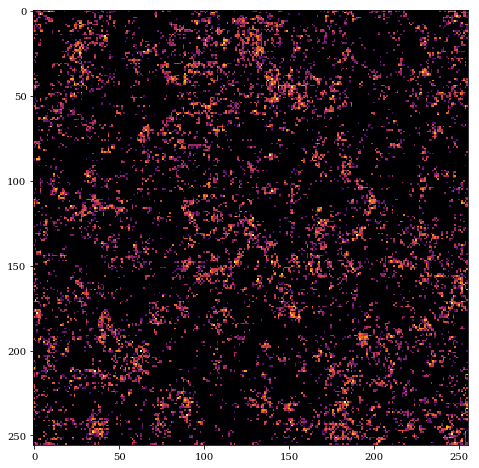

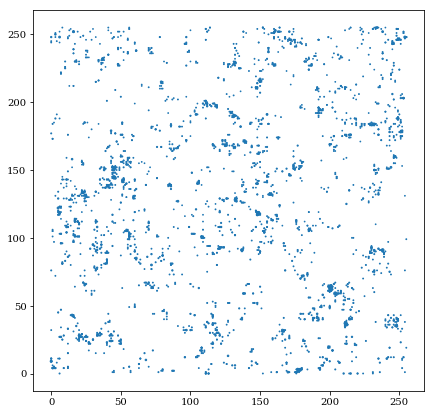

In [32]:
plt.figure(figsize=(7,7))
plt.scatter(halo_pos[idx, 1], halo_pos[idx, 0], s = 10 * halo_mass / halo_mass.max())
plt.show()

In [33]:
lya_field = np.zeros((256,256))
sb_lya = (nu_lya * I_gal(halo_mass[idx], z = 10.04)).value

for i in np.arange(halo_pos[idx, :].shape[0]):
    lya_field[halo_pos[idx, 1][i], halo_pos[idx, 0][i]] += sb_lya[i] * 3283

In [34]:
log_lya = np.log10(lya_field)
log_lya[np.isinf(log_lya)] = -12

/data4/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [35]:
plt.figure(figsize=(8,8))
plt.imshow(log_lya, cmap = 'inferno', vmax = -7)
#plt.colorbar()
plt.savefig('z_10.04_lya_gal.png', dpi = 200)

In [7]:
halo_rad = np.genfromtxt('21cmFAST/Output_files/Halo_lists/halos_radii_z7.04_768_200Mpc')

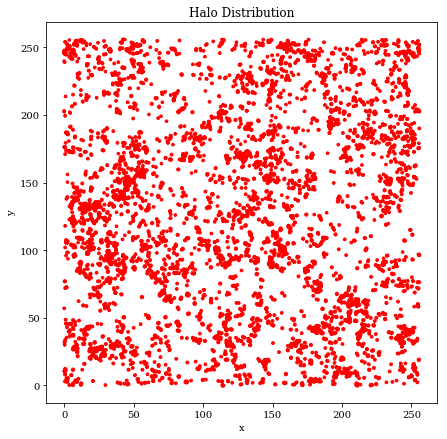

In [12]:
plt.figure(figsize=(14,7))
plt.title('Halo Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(halos[idxs,2]*256,halos[idxs,1]*256 , c='r',s=halo_rad/halo_rad.max()*20)
plt.show()

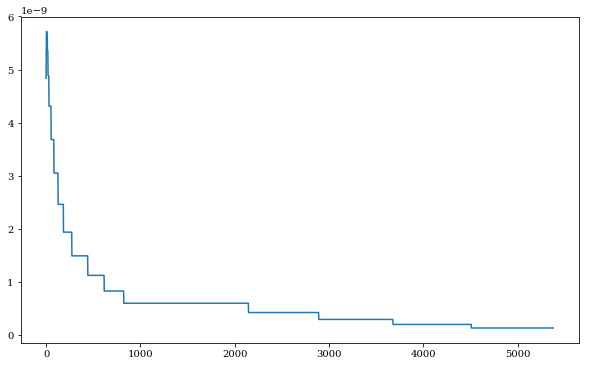

In [41]:
plt.figure(figsize=(10,6))
plt.plot(halo_I)
plt.show()

In [88]:
halo_lum = []
halo_I = []
z = 7.04

for m in halos[idxs,0]:
    halo_lum.append(L_gal(L_gal_exc(m,z), L_gal_rec(m,z)))

for i, r in enumerate(halo_rad[idxs]):
    halo_I.append(Lgal_to_I(halo_lum[i], r, z))

<type 'numpy.float64'>


TypeError: 'numpy.float64' object is not callable

In [42]:
np.sum(halo_I[:100])

4.199743390975464e-07

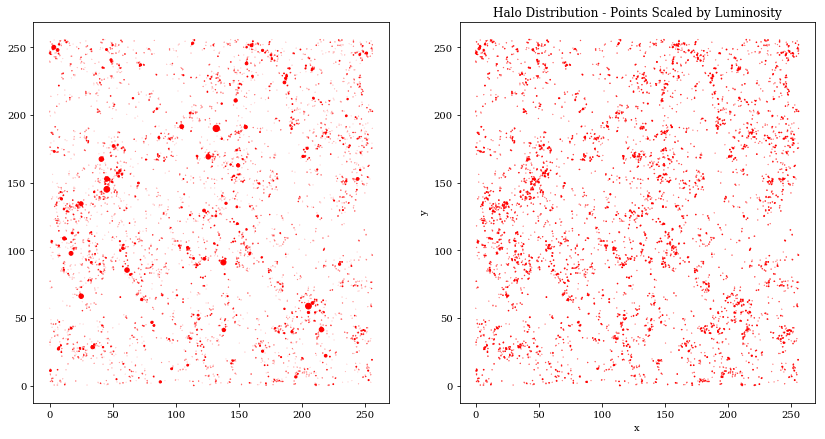

In [49]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.scatter(halos[idxs,2]*256,halos[idxs,1]*256 , c='r',s=halo_lum/max(halo_lum)*40)
plt.subplot(1,2,2)
plt.scatter(halos[idxs,2]*256,halos[idxs,1]*256 , c='r',s=halo_I/max(halo_I)*2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Halo Distribution - Points Scaled by Luminosity')
plt.show()

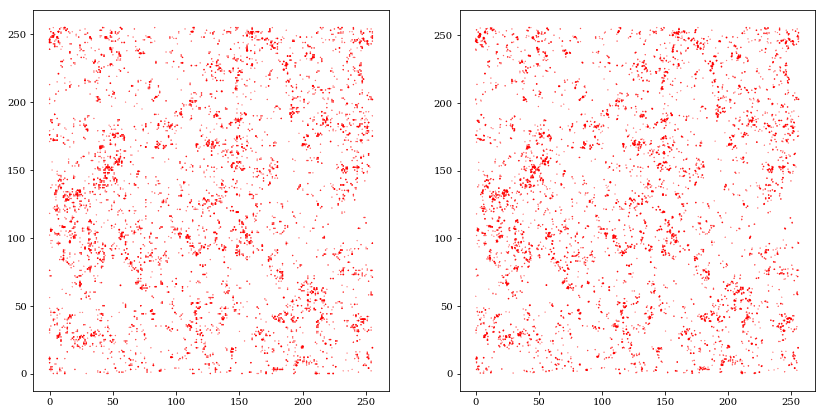

In [63]:
halo_x = (halos[idxs,2]*256).astype(int)
halo_y = (halos[idxs,1]*256).astype(int)

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.scatter(halo_x, halo_y,  c='r',s=halo_I/max(halo_I)*2)
plt.subplot(1,2,2)
plt.scatter(halos[idxs,2]*256,halos[idxs,1]*256 , c='r',s=halo_I/max(halo_I)*2)
plt.show()

In [54]:
L_exc = []
L_rec = []
L_tot = []

I_tot = []

for m in halos[idxs,0]:
    L_exc.append(L_gal_exc(m,z)/(24*60.0*60.0*365.0))
    L_rec.append(L_gal_rec(m,z)/(24*60.0*60.0*365.0))
    L_tot.append(L_gal(L_gal_exc(m,z), L_gal_rec(m,z)))

for i, r in enumerate(halo_rad[idxs]):
    I_tot.append(Lgal_to_I(L_tot[i], r, z))

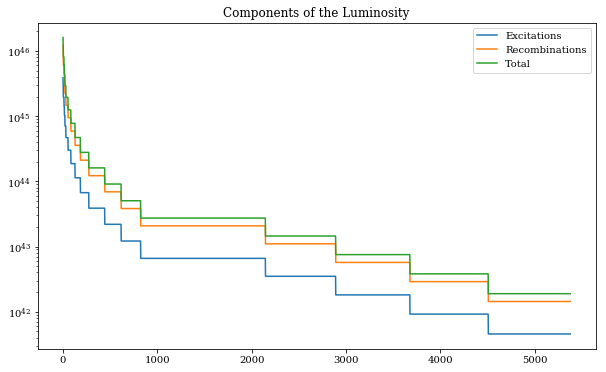

In [55]:
plt.figure(figsize=(10,6))
plt.plot(L_exc,label='Excitations')
plt.plot(L_rec,label='Recombinations')
plt.plot(L_tot,label='Total')
plt.yscale('log')
plt.title('Components of the Luminosity')
plt.legend()
plt.show()

In [70]:
halo_x = (halos[idxs,2]*256).astype(int)
halo_y = (halos[idxs,1]*256).astype(int)

gal_lya = np.zeros((256,256))

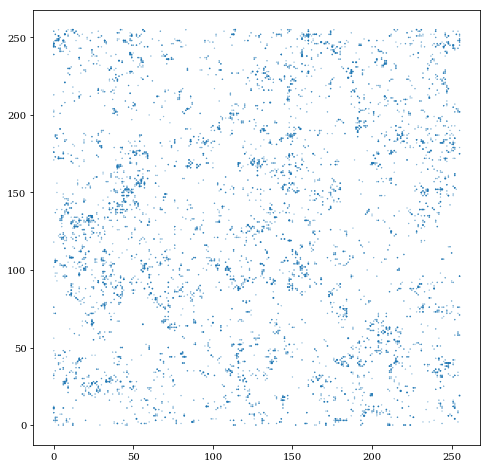

In [79]:
plt.figure(figsize=(8,8))
plt.scatter(halo_x, halo_y,s=halo_I/max(halo_I)*2)
plt.show()

In [71]:
for i in np.arange(halo_x.shape[0]):
    gal_lya[halo_x[i]][halo_y[i]] += I_tot[i]

/data4/tcox/src/anaconda2/envs/HERA/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


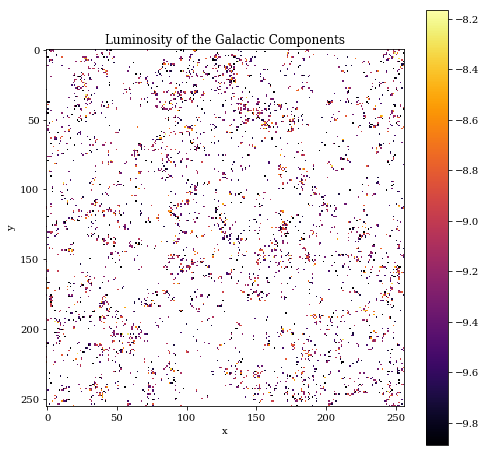

In [72]:
plt.figure(figsize=(8,8))
plt.imshow(np.log10(gal_lya), cmap=plt.cm.inferno)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Luminosity of the Galactic Components')
plt.colorbar()
plt.show()

## Compare Galaxy Map to Differential Brightness Temperature

In [16]:
f = 'runs/full_run_1/Boxes/delta_T_v3_z007.04_nf0.233584_useTs1_256_200Mpc'
dTb = load_binary_data(f)
dTb = dTb.reshape((256,256,256))[:,:,128]

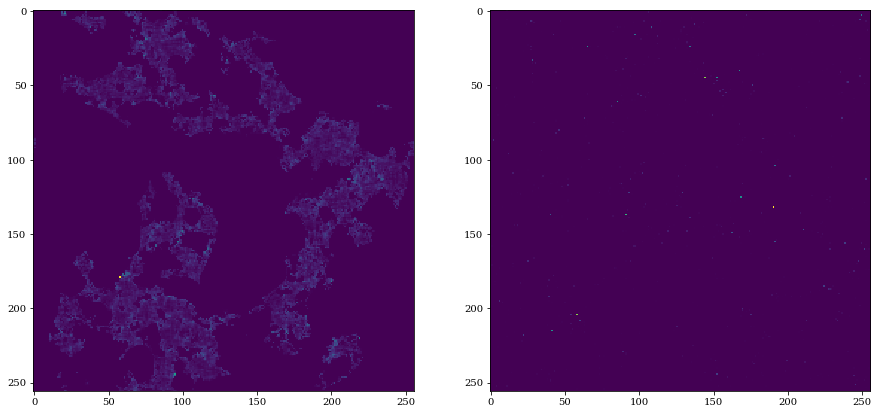

In [17]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(dTb/dTb.max())
plt.subplot(1,2,2)
plt.imshow(gal_lya/gal_lya.max())

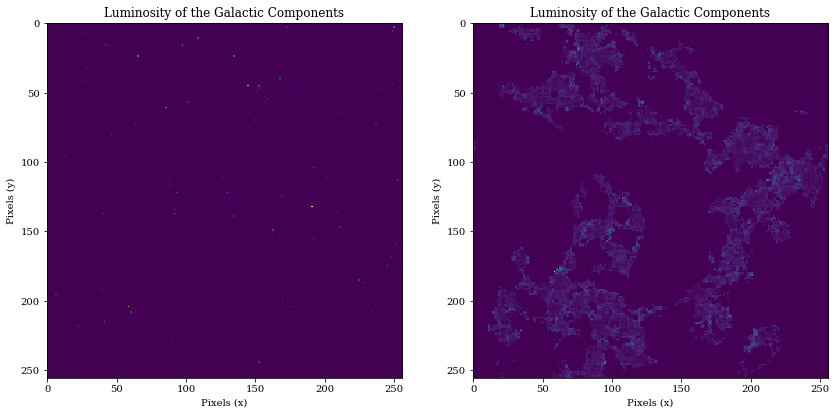

In [19]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(gal_lya/gal_lya.max())
plt.xlabel('Pixels (x)')
plt.ylabel('Pixels (y)')
plt.title('Luminosity of the Galactic Components')


plt.subplot(1,2,2)
plt.imshow(dTb)
plt.xlabel('Pixels (x)')
plt.ylabel('Pixels (y)')
plt.title('Luminosity of the Galactic Components')
plt.show()

## IGM Component

### IGM Ly$\alpha$ Luminosity Density Due to Recombination

$$l^{IGM}_{rec} = f_{rec} \dot{n}_{rec}(x,z) E_{Ly\alpha}$$

$$\dot{n}_{rec}(x,z) = \alpha_A n_e(z) n_{HII}(z)$$

$$n_e(z) = x_i n_b$$

$$ n_{HII}(z) = x_i n_b \left(4-4Y_{He} \right)/ \left( 4-3 Y_{He} \right) $$

In [20]:
def l_igm_rec(n_rec_slice, f_rec = 0.66, E_lya = 1.637e-11):
    '''
    E_lya units in ergs
    '''
    return f_rec*n_rec_slice*E_lya